<a href="https://colab.research.google.com/github/kishaiyan/Leaf_disease_prediction_TL_Efficient_net_b0/blob/main/Leaf_disease_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kishaiyanthangaraj","key":"64e49f0dba56b07dcf4be2773ebfb667"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

100% 2.70G/2.70G [00:29<00:00, 29.3MB/s]
100% 2.70G/2.70G [00:29<00:00, 97.9MB/s]


In [ ]:
import kaggle
import tensorflow as tf
import keras

In [ ]:
from zipfile import ZipFile
zf = ZipFile('new-plant-diseases-dataset.zip')
zf.extractall()
zf.close()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
gen_trn = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')
gen_valtst = ImageDataGenerator(rescale = 1./255)
# load and iterate train data
train_batch = gen_trn.flow_from_directory('New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/', class_mode='categorical', batch_size=64, seed=12, target_size = (128,128))
# Load and iterate val data
val_batch = gen_valtst.flow_from_directory('New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/', class_mode='categorical', batch_size=64, seed=123,  target_size = (128,128))
#Examine assigned class indices:
train_batch.class_indices
classes = train_batch.class_indices
classes

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Blueberry___healthy': 4,
 'Cherry_(including_sour)___Powdery_mildew': 5,
 'Cherry_(including_sour)___healthy': 6,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
 'Corn_(maize)___Common_rust_': 8,
 'Corn_(maize)___Northern_Leaf_Blight': 9,
 'Corn_(maize)___healthy': 10,
 'Grape___Black_rot': 11,
 'Grape___Esca_(Black_Measles)': 12,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13,
 'Grape___healthy': 14,
 'Orange___Haunglongbing_(Citrus_greening)': 15,
 'Peach___Bacterial_spot': 16,
 'Peach___healthy': 17,
 'Pepper,_bell___Bacterial_spot': 18,
 'Pepper,_bell___healthy': 19,
 'Potato___Early_blight': 20,
 'Potato___Late_blight': 21,
 'Potato___healthy': 22,
 'Raspberry___healthy': 23,
 'Soybean___healthy': 24,
 'Squash___Powdery_mildew': 25,
 'Strawberry___Leaf_scorch': 26,
 'Strawberry___healthy': 27,
 'Tomato___Bacterial_spot': 28,
 'Tomato___Early_blight': 29,
 'Toma

In [ ]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.utils import plot_model


In [ ]:
from keras.regularizers import l1

In [ ]:
!pip install efficientnet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.1 MB/s eta 0:00:00


In [ ]:
import efficientnet.keras as efn

In [ ]:
eff_net = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

eff_net.trainable = False


from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense,Dropout
from keras import Model

x = eff_net.output
x = Convolution2D(32, (3, 3), input_shape = (128,128,3), activation = 'sigmoid', padding = "same")(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Convolution2D(64, (3, 3), input_shape = (128,128,3), activation = 'sigmoid', padding = "same")(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Flatten()(x)
x = Dense(512, activation=tf.nn.swish)(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
predictions2a = Dense(38, activation="softmax")(x)
model_e_cnn2a = Model(inputs=eff_net.input, outputs=predictions2a)

16804768/16804768 [==============================] - 0s 0us/step


In [ ]:
model_e_cnn2a.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_e_cnn2a.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 64, 64, 32)           128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 64, 64, 32)           0         ['stem_bn[0][0]']         

In [ ]:
from time import process_time
t1_start = process_time()
ecnn_fit = model_e_cnn2a.fit_generator(
    train_batch,
    steps_per_epoch = 100,
    epochs = 50,
    validation_data = val_batch,
    validation_steps = 10
    )


# Stop the stopwatch / counter
t1_stop = process_time()

print("Elapsed time:", round((t1_stop-t1_start)/360,2),"m")

<ipython-input-14-23d53071529e>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  ecnn_fit = model_e_cnn2a.fit_generator(


Epoch 1/50
100/100 [==============================] - 122s 1s/step - loss: 3.3176 - accuracy: 0.0858 - val_loss: 2.6495 - val_accuracy: 0.2078
Epoch 2/50
100/100 [==============================] - 110s 1s/step - loss: 2.2716 - accuracy: 0.2827 - val_loss: 1.7786 - val_accuracy: 0.4250
Epoch 3/50
100/100 [==============================] - 110s 1s/step - loss: 1.6381 - accuracy: 0.4661 - val_loss: 1.4288 - val_accuracy: 0.5234
Epoch 4/50
100/100 [==============================] - 111s 1s/step - loss: 1.3987 - accuracy: 0.5394 - val_loss: 1.1643 - val_accuracy: 0.6109
Epoch 5/50
100/100 [==============================] - 114s 1s/step - loss: 1.3135 - accuracy: 0.5731 - val_loss: 1.0364 - val_accuracy: 0.6516
Epoch 6/50
100/100 [==============================] - 124s 1s/step - loss: 1.2020 - accuracy: 0.6008 - val_loss: 1.0646 - val_accuracy: 0.6438
Epoch 7/50
100/100 [==============================] - 116s 1s/step - loss: 1.0946 - accuracy: 0.6409 - val_loss: 0.9880 - val_accuracy: 0.6734

In [ ]:
import matplotlib.pyplot as plt

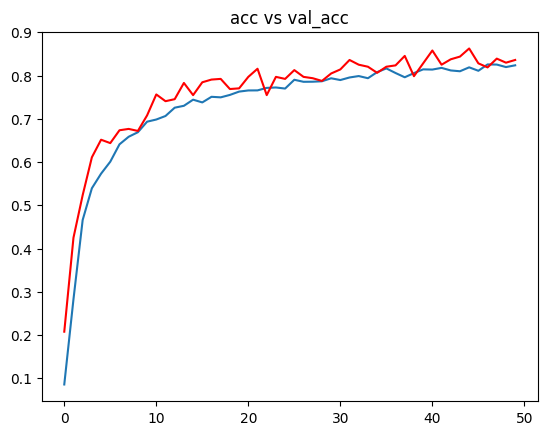

In [ ]:
his=ecnn_fit.history
plt.plot(his['accuracy'])
plt.plot(his['val_accuracy'],c='red')
plt.title('acc vs val_acc')
plt.show()

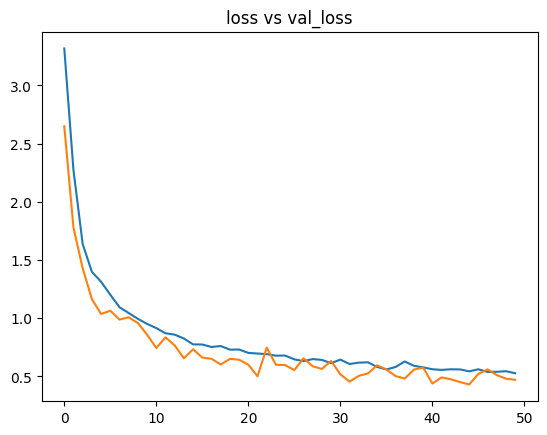

In [ ]:
plt.plot(his['loss'])
plt.plot(his['val_loss'])
plt.title('loss vs val_loss')
plt.show()

In [ ]:
from tensorflow.keras.models import save_model


In [ ]:
model_e_cnn2a.save('ecnn_fit.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model=load_model('ecnn_fit.h5')

In [ ]:
acc=model.evaluate(val_batch)[1]
print(f"accuracy of the current model is {acc*100} ",)

275/275 [==============================] - 246s 892ms/step - loss: 0.4419 - accuracy: 0.8538
accuracy of the current model is 85.38014888763428 


In [ ]:
ref=dict(zip(list(train_batch.class_indices.values()),list(train_batch.class_indices.keys())))

In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input

def prediction(path):
    img = load_img(path,target_size=(128,128))
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img,axis=0)
    pred = np.argmax(model.predict(img))
    return ref[pred]

In [ ]:
import os
for i in os.listdir('test/test'):
  pred=prediction(f'test/test/{i}')
  print(f'Actual=>{i}')
  print(f'Predicted=>{pred}')
  plt.show()

1/1 [==============================] - 0s 49ms/step
Actual=>TomatoHealthy3.JPG
Predicted=>Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
1/1 [==============================] - 0s 95ms/step
Actual=>PotatoEarlyBlight1.JPG
Predicted=>Apple___Black_rot
1/1 [==============================] - 0s 109ms/step
Actual=>TomatoEarlyBlight1.JPG
Predicted=>Strawberry___healthy
1/1 [==============================] - 0s 72ms/step
Actual=>AppleCedarRust3.JPG
Predicted=>Orange___Haunglongbing_(Citrus_greening)
1/1 [==============================] - 0s 51ms/step
Actual=>TomatoYellowCurlVirus1.JPG
Predicted=>Orange___Haunglongbing_(Citrus_greening)
1/1 [==============================] - 0s 53ms/step
Actual=>PotatoEarlyBlight2.JPG
Predicted=>Raspberry___healthy
1/1 [==============================] - 0s 62ms/step
Actual=>TomatoHealthy4.JPG
Predicted=>Potato___Early_blight
1/1 [==============================] - 0s 112ms/step
Actual=>AppleCedarRust1.JPG
Predicted=>Cherry_(including_sour)___healthy
1/1 [===